Aims:
- Label some BY4741 time series as oscillating vs non-oscillating.  50 for now, can increase when needed.
- Use this to train an SVM, then compute MI.
- See if it can tell apart oscillating and non-oscillating time series.

Specify file name and sampling period

In [15]:
filename_prefix = './data/arin/Omero19979_'
#filename_prefix = './data/arin/Omero20016_'
sampling_period = 5
remain = 0.8

%matplotlib inline

Main

In [37]:
#!/usr/bin/env python3
import os

import numpy as np
import scipy as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics
import igraph as ig

import pipeline.dataexport
import pipeline.dataimport
import pipeline.periodogram
import pipeline.score
import pipeline.tsman
import pipeline.vis

import featext.tsman
import featext.graph
#import featext.vis

#import catch22
#import leidenalg

def add_classicalAttr(cell, oversampling_factor = 1):
    """Computes classical periodogram and adds PdgramAttr attributes"""
    cell.flavin.classical.freqs, cell.flavin.classical.power = \
            pipeline.periodogram.classical(cell.time, cell.flavin.reading_processed,
                                oversampling_factor = oversampling_factor)

def add_bglsAttr(cell):
    """Computes BGLS and adds PdgramAttr attributes"""
    cell.flavin.bgls = pipeline.PdgramAttr()
    cell.flavin.bgls.label = 'Bayesian General Lomb-Scargle Periodogram'
    cell.flavin.bgls.power_label = 'Probability'
    err = np.ones(len(cell.flavin.reading_processed))*\
            np.sqrt(np.max(cell.flavin.reading_processed))
    cell.flavin.bgls.freqs, cell.flavin.bgls.power = \
            pipeline.periodogram.bgls(cell.time, cell.flavin.reading_processed, err,
                    plow = 30.0, phigh = 360.0, ofac = 5)

def add_autoregAttr(cell):
    """
    Computes autoregressive model-based periodogram and adds PdgramAttr
    attributes
    """
    cell.flavin.autoreg = pipeline.PdgramAttr()
    cell.flavin.autoreg.label = \
            'Autogressive Model-Based Periodogram (Jia & Grima, 2020)'
    cell.flavin.autoreg.power_label = 'Power'
    freq_npoints = 1000
    cell.flavin.autoreg.freqs, cell.flavin.autoreg.power = \
            pipeline.periodogram.autoreg(cell.time,
                                         cell.flavin.reading_processed,
                                         freq_npoints)

# FLAVIN: import data and process objects

# Import fluorescence info from CSVs
Dset_flavin = pipeline.dataimport.import_timeseries(
    filename_prefix+'flavin.csv', remain = remain)
# dummy so I get code to not complain; will be re-factored later
Dset_dcategory = [None] * len(Dset_flavin)
Dset_births = pipeline.dataimport.import_births(
    filename_prefix+'births.csv')

# Arranges information into DatasetAttr objects
Dset_data = pipeline.dataimport.CellAttr_from_datasets( \
        timeseries_df = Dset_flavin,
        categories_array = Dset_dcategory,
        births_df = Dset_births,
        sampling_pd = sampling_period)
Dset = pipeline.DatasetAttr(Dset_data)

# Add labels
strainlookup = pd.read_csv(filename_prefix+'strains.csv', \
                          index_col = 'position')
for ii, cell in enumerate(Dset.cells):
    cell.source = filename_prefix
    cell.medium.base = 'Delft'
    cell.medium.nutrients = {'glucose': 10}

    cell.strain = strainlookup.loc[cell.position].strain

    cell.flavin = pipeline.Fluo('flavin')
    cell.flavin.exposure = 60
    cell.flavin.reading = cell.y
    cell.flavin.category = Dset_dcategory[ii]


# mCherry: import data and process objects
try:
    Dset_mCherry_unsliced = pipeline.dataimport.import_timeseries(
        filename_prefix+'mCherry.csv', remain = remain)
    # restrict to cells with flavin readings
    idx_both = list(set(Dset_flavin.cellID) & set(Dset_mCherry_unsliced.cellID))
    Dset_mCherry = \
            Dset_mCherry_unsliced.loc[Dset_mCherry_unsliced.cellID.isin(idx_both)]

    # Arranges information into DatasetAttr objects
    # dummy -- will be better when I re-structure things... am just re-using a 
    # function for quick-and-dirty purposes, and it's obviously redundant
    mCherry_data = pipeline.dataimport.CellAttr_from_datasets( \
            timeseries_df = Dset_mCherry,
            categories_array = Dset_dcategory,
            births_df = Dset_births,
            sampling_pd = sampling_period)
    mCherry = pipeline.DatasetAttr(mCherry_data)
    mCherry_MATLABids = [cell.MATLABid for cell in mCherry.cells]

    # Add labels
    for ii, cell in enumerate(Dset.cells):
        cell.mCherry = pipeline.Fluo('mCherry')
        if cell.strain == 'htb2_mCherry_CRISPR':
            cell.mCherry.exposure = 100
        else:
            cell.mCherry.exposure = 0

        # loads in reading, cross-referencing by MATLABid.  This is awful, I know.
        if cell.MATLABid in mCherry_MATLABids:
            cell.mCherry.reading = \
                mCherry.cells[mCherry_MATLABids.index(cell.MATLABid)].y
except FileNotFoundError as error:
    print(error)
    print(f'No mCherry time series associated with this experiment: {filename_prefix}')

[Errno 2] No such file or directory: './data/arin/Omero19979_mCherry.csv'
No mCherry time series associated with this experiment: ./data/arin/Omero19979_


Define working dataset (list of cells)

In [38]:
Wlist = Dset.cells
#Wlist = [cell for cell in Dset.cells if cell.strain == 'swe1_Del']
len(Wlist)

589

Chop up time series

In [ ]:
interval_start = 0
interval_end = 168

for cell in Wlist:
    cell.time = cell.time[interval_start:interval_end]
    cell.flavin.reading = cell.flavin.reading[interval_start:interval_end]

Remove cells that have NaNs, counts number of cells in each strain

In [39]:
Wlist = [cell for cell in Wlist if not np.isnan(cell.flavin.reading).any()]
from collections import Counter
count_strain = Counter([cell.strain for cell in Wlist])
print(count_strain)

Counter({'CEN_PK_Mat_A': 78, 'rim11_Del': 72, 'swe1_Del': 31, 'tsa1_Del_tsa2_Del': 29, 'FY4': 25})


Normalise

In [40]:
for cell in Wlist:
    cell.flavin.reading_processed = (cell.flavin.reading - np.mean(cell.flavin.reading))/np.std(cell.flavin.reading)

Score oscillations (human)

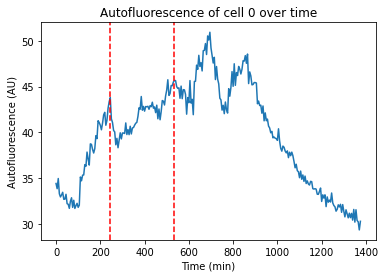

Is this oscillatory?: 0


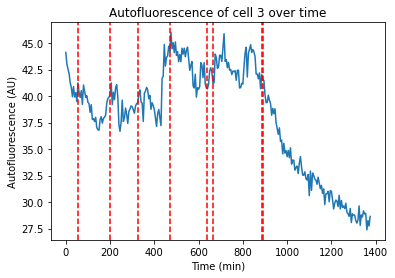

Is this oscillatory?: 0


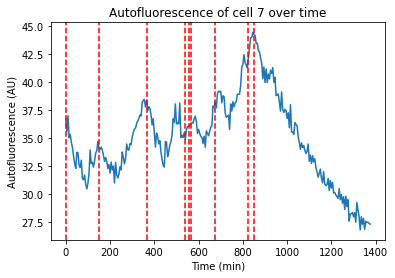

Is this oscillatory?: 1


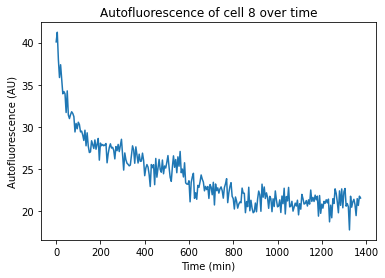

Is this oscillatory?: 0


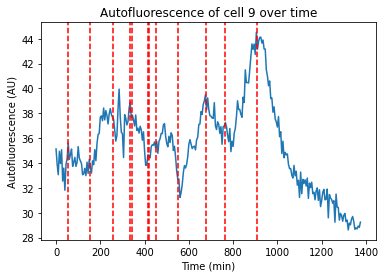

Is this oscillatory?: 0


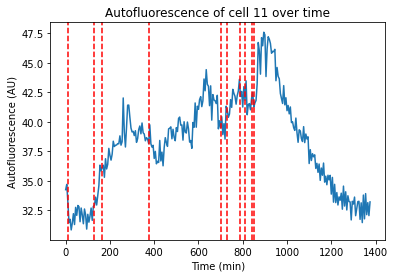

Is this oscillatory?: 0


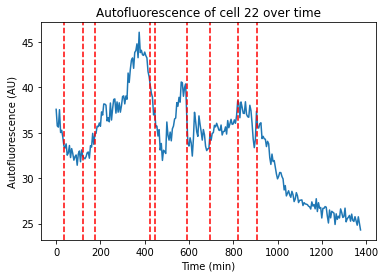

Is this oscillatory?: 0


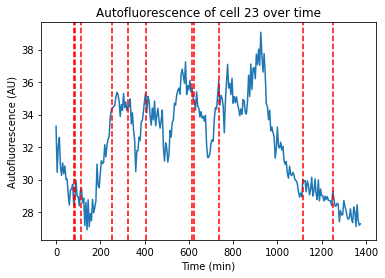

Is this oscillatory?: 0


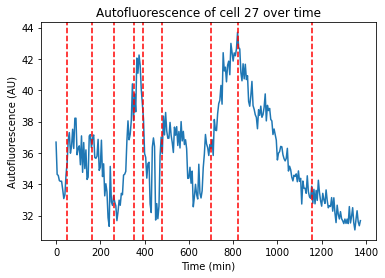

Is this oscillatory?: 0


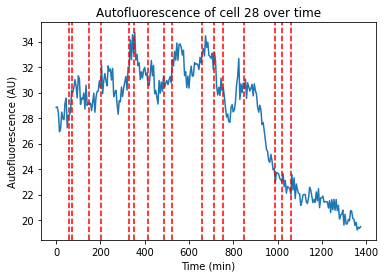

Is this oscillatory?: 1


In [41]:
sample_dataset_indices = range(10)
for index in sample_dataset_indices:
    Wlist[index].plot_ts(y_attr='flavin.reading')
    plt.show(block=False)
    Wlist[index].flavin.category = input('Is this oscillatory?: ')

In [42]:
import pandas as pd

osc_list = [cell.flavin.category for cell in Wlist]
freq_table = pd.Series(osc_list).value_counts()
print(freq_table)

0    8
1    2
dtype: int64


Put oscillations into array input for MI

In [80]:
categories = ['0', '1']

mi_data = [
    np.vstack(tuple(
        [cell.flavin.reading_processed
             for cell in Wlist
             if cell.flavin.category == category]))
    for category in categories
]

Or, by strain:

In [49]:
#strains = list(set([cell.strain for cell in Wlist]))
strains = ['swe1_Del', 'tsa1_Del_tsa2_Del']

mi_data = [
    np.vstack(tuple(
        [cell.flavin.reading_processed
             for cell in Wlist
             if cell.strain == strain]))
    for strain in strains
]

In [50]:
mi_data

[array([[-1.86917219, -2.04089616, -1.97797216, ...,  1.66088933,
          1.3656424 ,  1.45738891],
        [-1.27632943, -1.43621368, -1.49950347, ...,  0.61708206,
          0.42465076,  0.32452568],
        [-2.43277353, -2.43902802, -2.73414327, ...,  0.30622797,
          0.55197449,  0.30418226],
        ...,
        [-2.22991593, -1.86005539, -1.4873624 , ...,  0.65442101,
          0.84397989,  1.0597527 ],
        [-2.66872672, -2.34234173, -2.20808041, ..., -0.13847603,
          0.33239024,  0.1093331 ],
        [-2.13672385, -2.58222934, -2.35883436, ...,  0.40147182,
          0.57026446,  0.43269727]]),
 array([[-1.36549359, -1.74910482, -2.07916271, ..., -0.38394109,
         -0.23137057, -0.24624847],
        [-0.97529791, -1.77841199, -1.53551423, ...,  2.43399703,
          2.68873961,  3.09984325],
        [-1.50366265, -1.63215385, -1.74474715, ...,  0.30643262,
          0.29294117,  0.24536684],
        ...,
        [-2.78965044, -2.71249339, -2.53713874, ...,  

In [51]:
from MIdecoding import estimateMI, plotMIovertime

results = estimateMI(mi_data, verbose=True, overtime=False, n_bootstraps=1000)

duration of time series is 276
Pipeline(steps=[('project', PCA()), ('rescale', StandardScaler()),
                ('classifier',
                 SVC(C=2.154434690031882, gamma=0.004641588833612777))])
median MI= 0.08 [0.02, 0.17]
duration of time series is 276
Pipeline(steps=[('project', PCA()), ('rescale', StandardScaler()),
                ('classifier',
                 SVC(C=2.154434690031882, gamma=0.004641588833612777))])
median MI= 0.08 [0.03, 0.17]


In [48]:
results

{'0': array([[0.66981846, 0.5768249 , 0.78069647]]),
 '1': array([[0.67757238, 0.5787874 , 0.77802329]])}